# Evolution Algorithm

In [1]:
# setup Google Colaboratory
!mkdir models
!mkdir data
!mkdir data/stock_prices
!mkdir evolution_model_graphs

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/stock_prices’: File exists
mkdir: cannot create directory ‘evolution_model_graphs’: File exists


## Import dependencies

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from os import path

In [0]:
from build_dataset import build_dataset

In [4]:
from models.dnn_regression import DenseNeuralNetwork

Using TensorFlow backend.


In [0]:
import json
from keras.callbacks import TensorBoard
from keras.utils import plot_model

## Get last run data

In [0]:
last_run = None
if path.isfile("last_run.json"):
    with open("last_run.json", "r") as last_run_file:
        last_run = json.load(last_run_file)

## Initialize models

In [7]:
if last_run is not None:
    last_top_models = []
    last_error_idx_sorted = np.argsort(last_run["evolution_errors"][-1])
    for last_top_model_idx in last_error_idx_sorted[:2]:
        last_top_models.append(DenseNeuralNetwork(
            last_run["last_models"][last_top_model_idx]["model_options"],
            last_run["last_models"][last_top_model_idx]["input_options"],
            last_run["last_models"][last_top_model_idx]["stock_code"]
        ))
    models, mutations = DenseNeuralNetwork.evolve(last_top_models, 10)
    for mutation in mutations:
        print(mutation)
else:
    # initialize some random models
    models = DenseNeuralNetwork.random_models(10, "dense")
    for i, model in enumerate(models):
        print("Model {}".format(i))
        print(json.dumps(model.model_options, indent=4))

Model 0
{
    "net": {
        "layers": [
            {
                "layer_type": "dense"
            }
        ],
        "loss": "mse",
        "optimizer": "Adam",
        "learning_rate": 0.0001,
        "epochs": 50,
        "batch_size": 32,
        "metrics": [
            "mse"
        ]
    },
    "predict_n": 10,
    "network_type": "dense"
}
Model 1
{
    "net": {
        "layers": [
            {
                "layer_type": "dense"
            }
        ],
        "loss": "mse",
        "optimizer": "Adam",
        "learning_rate": 0.0001,
        "epochs": 10,
        "batch_size": 32,
        "metrics": [
            "mse"
        ]
    },
    "predict_n": 10,
    "network_type": "dense"
}
Model 2
{
    "net": {
        "layers": [
            {
                "layer_type": "dense"
            }
        ],
        "loss": "mse",
        "optimizer": "Adam",
        "learning_rate": 0.01,
        "epochs": 100,
        "batch_size": 64,
        "metrics": [
       

## Evolution algorithm

In [0]:
evolution_errors = last_run["evolution_errors"] if last_run is not None else []

In [0]:
best_models = last_run["best_models"] if last_run is not None else []

In [0]:
last_iterations = last_run["last_iterations"] if last_run is not None else 0
iterations = 1

In [11]:
for i in range(last_iterations, last_iterations + iterations):
    errors = []

    for model_idx, model in enumerate(models):
        print("Iteration {0}, Model {1}".format(i + 1, model_idx + 1))
        
        # prepare the data
        x, y = build_dataset(model.input_options, model.model_options["predict_n"], True)
        # split the data into training set and testing set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
        # train the model
        model.train(
            x_train,
            y_train,
            verbose=0,
            callbacks=[TensorBoard(log_dir="./evolution_tensorboard_logs/{}_{}".format(i + 1, model_idx + 1))]
        )
        # calculate the model error
        error = model.model.evaluate(x_test, y_test, verbose=0)
        errors.append(error[-1])

    evolution_errors.append(errors)
    
    # select top models
    error_idx_sorted = np.argsort(errors)
    top_models = [models[i] for i in error_idx_sorted[:2]]
    
    print("Best model")
    print(json.dumps(top_models[0].model_options, indent=4))
    print(json.dumps(top_models[0].input_options, indent=4))
    plot_model(top_models[0].model, to_file="evolution_model_graphs/{}.png".format(i + 1))

    # cross-over models and breed new models
    if i < iterations - 1:
        models, mutations = DenseNeuralNetwork.evolve(top_models, 10)
        for mutation in mutations:
            print(mutation)
    
    print()

Iteration 1, Model 1
Iteration 1, Model 2
Iteration 1, Model 3
Iteration 1, Model 4
Iteration 1, Model 5
Iteration 1, Model 6
Iteration 1, Model 7
Iteration 1, Model 8
Iteration 1, Model 9
Iteration 1, Model 10
Best model
{
    "net": {
        "layers": [
            {
                "layer_type": "dense"
            }
        ],
        "loss": "mse",
        "optimizer": "Adam",
        "learning_rate": 0.01,
        "epochs": 50,
        "batch_size": 32,
        "metrics": [
            "mse"
        ]
    },
    "predict_n": 10,
    "network_type": "dense"
}
{
    "config": [
        {
            "type": "lookback",
            "n": 22,
            "stock_code": "GOOGL",
            "column": "adjusted_close"
        },
        {
            "type": "moving_avg",
            "n": 5,
            "stock_code": "GOOGL",
            "column": "adjusted_close"
        },
        {
            "type": "moving_avg",
            "n": 10,
            "stock_code": "GOOGL",
            "

In [0]:
# get the best model
best_model_idx = np.argmin(evolution_errors[-1])
best_model = models[best_model_idx]
best_models.append({
    "model_options": best_model.model_options,
    "input_options": best_model.input_options,
    "stock_code": best_model.stock_code
})

## Write this run data

In [0]:
with open("last_run.json", "w") as last_run_file:
    json.dump({
        "last_iterations": last_iterations + iterations,
        "last_models": [{
            "model_options": model.model_options,
            "input_options": model.input_options,
            "stock_code": model.stock_code
        } for model in models],
        "evolution_errors": evolution_errors,
        "best_models": best_models
    }, last_run_file, indent=4)

In [14]:
!zip -r evolution_tensorboard_logs.zip evolution_tensorboard_logs
!zip -r evolution_model_graphs.zip evolution_model_graphs

  adding: evolution_tensorboard_logs/ (stored 0%)
  adding: evolution_tensorboard_logs/1_2/ (stored 0%)
  adding: evolution_tensorboard_logs/1_2/events.out.tfevents.1548732910.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensorboard_logs/1_8/ (stored 0%)
  adding: evolution_tensorboard_logs/1_8/events.out.tfevents.1548732947.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensorboard_logs/1_3/ (stored 0%)
  adding: evolution_tensorboard_logs/1_3/events.out.tfevents.1548732914.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensorboard_logs/1_7/ (stored 0%)
  adding: evolution_tensorboard_logs/1_7/events.out.tfevents.1548732940.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensorboard_logs/1_5/ (stored 0%)
  adding: evolution_tensorboard_logs/1_5/events.out.tfevents.1548732930.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensorboard_logs/1_4/ (stored 0%)
  adding: evolution_tensorboard_logs/1_4/events.out.tfevents.1548732928.d6ae92a1c09c (deflated 90%)
  adding: evolution_tensor

## Plot predictions

In [0]:
import pandas as pd

In [0]:
import matplotlib.pyplot as plt

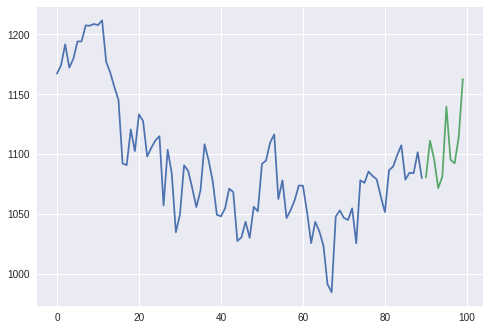

In [17]:
stock_prices = pd.read_csv("./data/stock_prices/" + model.stock_code + ".csv", index_col=0)["adjusted_close"].values[::-1]
stock_prices = stock_prices[-90:]
x = build_dataset(best_model.input_options, best_model.model_options["predict_n"], False)
prediction = best_model.predict(x)
plt.plot(np.arange(len(stock_prices)), stock_prices)
plt.plot(np.arange(len(stock_prices), len(stock_prices) + len(prediction)), prediction)

## Plot evolution data

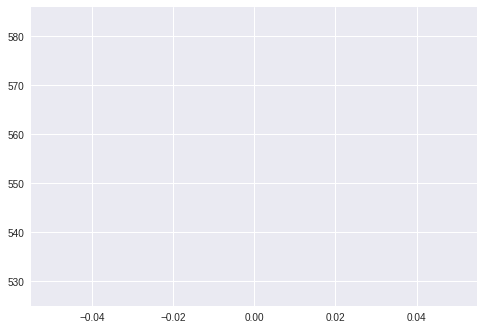

In [18]:
# plot evolution errors
plt.plot(np.arange(len(evolution_errors)), np.nanmin(evolution_errors, axis=1))